# Propheto: Iris Classification Example Notebook
-----------

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Propheto-io/propheto/blob/main/docs/Propheto%20Iris%20Classification.ipynb)

This notebook outlines a sample usecase for building and deploying a machine learning model with Propheto. We use the Iris dataset from scikit learn and build a model with scikit learns SGDClassifier module. We then deploy that model to AWS as a serverless microservice behind a RESTful API with all of the logging, monitoring, and reporting we need tied into our Propheto platform.

This tutorial runs on **python 3.8** and uses the **matplotlib, seaborn, jupyter, pandas, numpy scikit-learn, tqdm, boto3,** and **propheto** python packages.

## Contents
* [Singup for accounts](#2)
* [Install Packages](#3)
* [Import libraries](#4)
* [Extract and load data](#5)
* [Train model](#6)
* [Evaluate model performance](#7)
* [Deploy](#8)
* [Destroy](#9)


## Signup for accounts

The first step before starting this notebook tutorial, is to get your accounts ready. If you havent already be sure you signup for an account with AWS and with Propheto. 

For this demonstration, you will be able to use the free tier that is offered by AWS but if you havent signed up with them yet, you will need to create an account and provide credit card information, all of which can be done at https://portal.aws.amazon.com/billing/signup#/start ![alt text](https://github.com/Propheto-io/propheto/blob/main/docs/images/portal.aws.amazon.com_billing_signup.png?raw=true)

You will also need to sign up for a Propheto account. Your Propheto account allows you to view and manage your  at https://app.getpropheto.com ![alt text](https://github.com/Propheto-io/propheto/blob/main/docs/images/app.getpropheto.com_auth_type=sign-up.png?raw=true)

## Install Packages

#### Install AWS CLI 
In order to use Propheto, you need to have the AWS CLI configured with your AWS Credentials. Download AWS CLI from the following location https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-install.html. 

Once the CLI is installed in your development environment you then want to configure the AWS CLI to connect to your AWS account https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

**Make sure the AWS account you use has the proper permissions.** In order to use this propheto tutorial, your account needs to be able to create a new IAM role, lambda functions, S3, CodeBuild, ECR, and APIGateway.    

#### Install propheto python package
Next we will install the required packages for this tutorial. In this tutorical we will be building our model using many of the standard Python ML libraries. If you dont have them installed, you can install them by running the following command `pip install matplotlib seaborn jupyter scikit-learn tqdm` 

Then you can install the propheto python package using `pip install propheto`

In [1]:
!pip install matplotlib seaborn jupyter scikit-learn tqdm
!pip install propheto

  Using cached matplotlib-3.4.3-cp38-cp38-manylinux1_x86_64.whl (10.3 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached scikit_learn-1.0.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (25.9 MB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)


  Using cached propheto-0.1.7-py3-none-any.whl (61 kB)


## Import Libraries

Now we can begin building our model. We will start by importing all of the python libraries we will use for this tutorial. 

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Next we will instantiate a propheto object for this specific project. This will authenticate our account with Propheto and create a new project directory on our dev environment.

In [3]:
# Import Propheto Package
from propheto import Propheto

# Instanciate Propheto with new project name, description, version number and credential details
propheto = Propheto(
    name="Sample Propheto Project - Iris classification",  # Project Name
    description="This is my sample Propheto project with the iris dataset",  # Project Description
    version="0.1.0",  # Version for Project/API
    experiment="Initial experiment",  # Details for experiment or experiment version
    # Authentication username/password
    credentials={
        "email": USER_EMAIL_ADDRESS, 
        "password": USER_PASSWORD
    },
)
propheto


<IPython.core.display.Javascript object>

Created project directory...


Propheto(id=hszs6GGbUr8PLtdZsn3f, project_name=Sample Propheto Project - Iris classification, version=0.1.0)

### EXTRACT AND LOAD DATA
Now we will extract our Iris dataset and do some simple data exploration.

In [4]:
# LOAD IRIS DATASET
iris = datasets.load_iris(as_frame=True)
iris_data = iris['data']
iris_target = iris['target']
iris_df = pd.concat([iris_data, iris_target], axis=1)
# We can log information back into propheto using the propheto.log command.
propheto.log('data-sample', iris_df.head(), type='table', annotate="Sample records processed")
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


#### Log sample information back into Propheto

In [5]:
# Propheto allows you to easily annotate these results so you can view them later in the dashboard
propheto.log('data-desc', iris_df.describe(), type='table', annotate="Description of the data being processed")
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


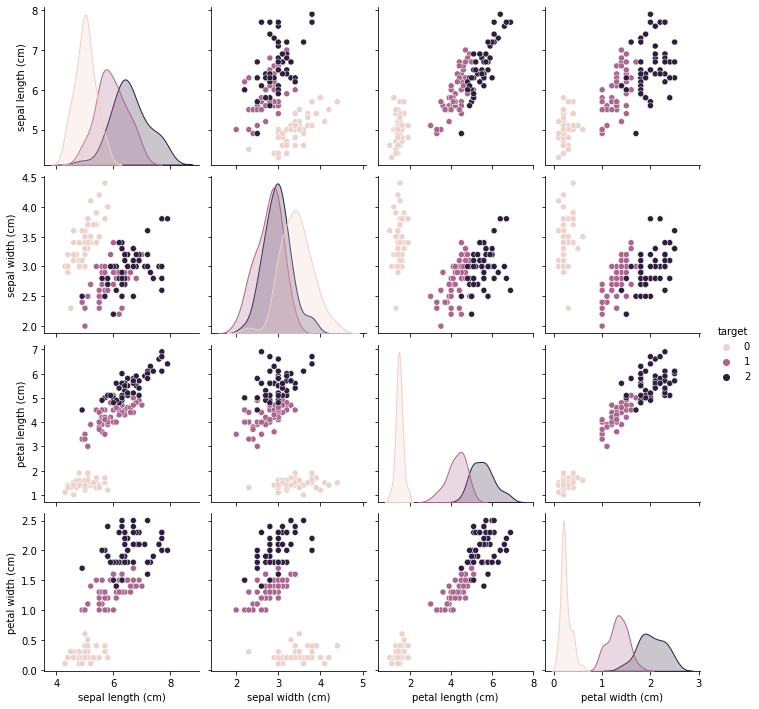

In [6]:
# You can alos log plots in Propheto to more easily visualize data.
sns.pairplot(iris_df, hue='target')
propheto.log('iris-pairplot', plt, type='plot', annotate='pairplot iris df')
plt.show()

## Train Model
We can train our model and split our features

In [7]:
y = iris_df.pop('target')

# Just training on the first two features
X = iris_df[iris.feature_names[:2]].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X_train, y_train)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, max_iter=100)

## Evaluate Model Performance
Now let's see how our model performed

In [8]:
target_names = iris.target_names
y_pred = clf.predict(X_test)
y_true = y_test
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      setosa       0.95      1.00      0.97        19
  versicolor       0.48      0.93      0.64        15
   virginica       1.00      0.06      0.12        16

    accuracy                           0.68        50
   macro avg       0.81      0.67      0.58        50
weighted avg       0.83      0.68      0.60        50



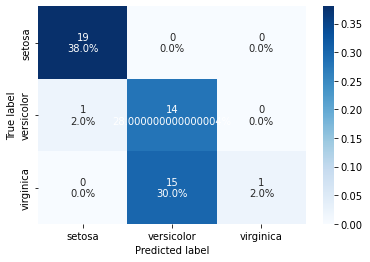

In [9]:
cf_matrix = confusion_matrix(y_true, y_pred)

cf_percents = cf_matrix/np.sum(cf_matrix)

annotations = []
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        v1 = cf_matrix[i][j]
        v2 = cf_percents[i][j]*100
        _annotate = f"{v1}\n{v2}%".strip()
        annotations.append(_annotate)
annotations = np.array(annotations).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

sns.heatmap(
    cf_matrix/np.sum(cf_matrix), 
    annot=annotations, 
    fmt='', 
    cmap='Blues', 
    xticklabels=iris.target_names,
    yticklabels=iris.target_names
)

plt.ylabel('True label')
plt.xlabel('Predicted label')

propheto.log('Confusion-matrix', plt, type='plot', annotate='Test confusion matrix')
plt.show()

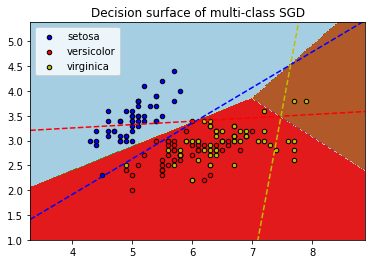

In [10]:
# Borrowing from Scikit-learn's documentation on ploting the decision surface

colors = "bry"

# standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

h = .02  # step size in the mesh

# create a mesh to plot in
X = iris['data'].values[:, :]
y = iris.target.values
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('tight')

# Plot also the training points
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.Paired, edgecolor='black', s=20)
plt.title("Decision surface of multi-class SGD")
plt.axis('tight')

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_


def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)


for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)
plt.legend()

propheto.log('pred-contor-plot', plt, type='plot', annotate='Decision Boundry')
plt.show()

## Deploy Model
Once we are happy with the performance of our model. We can deploy it and start making calls to our model as an API service. We can deploy our model locally or deploy directly to our AWS account with one command: `propheto.deploy`

### Deploy locally

In [11]:
propheto.deploy(clf, target='local')

<IPython.core.display.Javascript object>

Generated App Service...
/home/dan/dev/propheto/package/propheto/docs/propheto-package
Creating Dockerfile...
Creating requirements...
  Using cached asgiref-3.4.1-py3-none-any.whl (25 kB)
  Using cached boto3-1.17.112-py2.py3-none-any.whl (131 kB)
  Using cached botocore-1.20.112-py2.py3-none-any.whl (7.7 MB)
  Using cached click-8.0.1-py3-none-any.whl (97 kB)
  Using cached fastapi-0.66.0-py3-none-any.whl (51 kB)
  Using cached h11-0.12.0-py3-none-any.whl (54 kB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached mangum-0.11.0-py3-none-any.whl (11 kB)
  Using cached numpy-1.21.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached pandas-1.3.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (10.6 MB)
  Using cached pydantic-1.8.2-cp38-cp38-manylinux2014_x86_64.whl (13.7 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pytz-2021.1-py2.py3

You should consider upgrading via the '/home/dan/dev/propheto/package/propheto/docs/propheto-package/env/bin/python3 -m pip install --upgrade pip' command.


Created virtual environment...
Server running locally. You can test the api now at http://127.0.0.1:8000 and check the /docs endpoint
If you'd like to see your model in our app, you need to expose your localhost and update the project
Check out your project in Propheto at: https://app.getpropheto.com/projects/hszs6GGbUr8PLtdZsn3f


INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [21595] using statreload
INFO:     Started server process [21597]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


If we navigate to our running server documentation at [http://127.0.0.1:8000/docs](http://127.0.0.1:8000/docs) we can see a simple and interactive Swagger style API documentation for our ML service. We can test the various endpoints and see what the responses are from each here.
![alt text](https://github.com/Propheto-io/propheto/blob/main/docs/images/localhost-api-docs.png?raw=true)

### Test deployment
Once we have our model deployed and our service running, we can test our API

In [12]:
import requests

base_url = propheto.config.service_api_url
predict_url = f"{base_url}/v1/models/predict"

response = requests.post(predict_url, json=[[5.1, 3.5]])
print(response.json())

{'code': 200, 'message': 'Success', 'result': {'prediction': 1}}


We can also expose our local API to Propheto so we can view the output of our logs and interact with our model endpoints in the propheto app.

To do this we will have to use a tunneling tool like [http://localhost.run/](http://localhost.run/). In a new terminal, enter 

```s
ssh -R 80:localhost:8000 localhost.run
```

The output will look something like the following
![alt text](https://github.com/Propheto-io/propheto/blob/main/docs/images/localhostrun-image.png?raw=true)

Be sure to note the URL for the service that is returned as we will need to pass this as an argument to Propheto.


In [13]:
# Using the previous localhost tunnel URL update your propheto config
propheto.config.service_api_url = URL_LOCALHOST_RUN  # Something like "https://d4ab3dd76f6898.lhr.domains"

# Write config locally to project folder
propheto.config.write_config()

# Update the project config in Propheto
propheto.api.update_project(project_id=propheto.id, payload=propheto.config.to_dict())

{'message': 'Project updated sucessfully'}

In [14]:
# Once we've tested it out we can kill our service
propheto.deployment.kill_server()

# Be sure we stop the local host tunnel as well

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [21597]
INFO:     Stopping reloader process [21595]


### Deploy to AWS
We can also deploy our model to AWS directly. The resources used should all fall under the free tier and this is a very easy way to get Propheto up and running.

In [15]:
propheto.deploy(
    clf, 
    target='aws', 
    profile_name="default",  # Optional AWS profile name. Can use "default"
    region="us-east-1" # Optional specify the region to deploy service
)

<IPython.core.display.Javascript object>

Created ECR Repository...
Created S3 bucket...
model.sav
Uploading SampleProphetoProject-Irisclassification/model.sav (1.1KiB)..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.16k/1.16k [00:00<00:00, 13.3kB/s]


Uploaded ML model...
Uploading SampleProphetoProject-Irisclassification/logs/propheto-log-data-sample.json (1017.0B)..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 10.5kB/s]


Uploading SampleProphetoProject-Irisclassification/logs/propheto-log-iris-pairplot.json (212.5KiB)..


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218k/218k [00:00<00:00, 723kB/s]


Uploading SampleProphetoProject-Irisclassification/logs/propheto-log-Confusion-matrix.json (20.5KiB)..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21.0k/21.0k [00:00<00:00, 237kB/s]


Uploading SampleProphetoProject-Irisclassification/logs/propheto-log-data-desc.json (1.6KiB)..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.61k/1.61k [00:00<00:00, 14.6kB/s]


Uploading SampleProphetoProject-Irisclassification/logs/propheto-log-pred-contor-plot.json (32.2KiB)..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33.0k/33.0k [00:00<00:00, 219kB/s]


Uploaded local logs
Generated App Service...
Creating Dockerfile...
Creating requirements...
Creating buildspec...
Zipped service...
Uploading SampleProphetoProject-Irisclassification/lambda.zip (4.9KiB)..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.97k/4.97k [00:00<00:00, 57.1kB/s]


Uploaded zipped service...
Building image...
Build in progress... Status: IN_PROGRESS - 1/30
Build in progress... Status: IN_PROGRESS - 2/30
Build in progress... Status: IN_PROGRESS - 3/30
Build in progress... Status: IN_PROGRESS - 4/30
Build in progress... Status: IN_PROGRESS - 5/30
Build in progress... Status: IN_PROGRESS - 6/30
Build in progress... Status: IN_PROGRESS - 7/30
Build in progress... Status: IN_PROGRESS - 8/30
Build in progress... Status: SUCCEEDED - 9/30
Build completed successfully!
Function status Pending
Function status Pending
Function status Pending
Function status Pending
Function status Active
Created lambda function...
Created API...
Deployed API! -  https://itgtoc5bki.execute-api.us-east-1.amazonaws.com/dev
Created Cloudwatch Keepwarm...
Check out your project in Propheto at: https://app.getpropheto.com/projects/hszs6GGbUr8PLtdZsn3f


We can view details regarding what resources we created using the `propheto.config.to_dict()` command or by viewing our `propheto.config` file located in the `propheto-package` directory

In [ ]:
# Output resources used and deployed
propheto.config.to_dict()

If we navigate to our dashboard we will be able to view details for our model and have a simple view to the logs that we created during our model training as well ![alt text](https://github.com/Propheto-io/propheto/blob/main/docs/images/app.getpropheto.com_projects_=report.png?raw=true)

We can also view the Swagger API documentation directly in Propheto. All you need to do is navigate to the `api` tab and you should see something like the following ![alt text](https://github.com/Propheto-io/propheto/blob/main/docs/images/api-page-image.png?raw=true)

## Test The Deployment
Now that your model is deployed you can make API calls and test it out.

In [16]:
import requests

base_url = propheto.config.service_api_url
predict_url = f"{base_url}/v1/models/predict"

response = requests.post(predict_url, json=[[5.1, 3.5]])
print(response.json())

{'code': 200, 'message': 'Success', 'result': {'prediction': 0}}


## Delete Deployment
Once we finish with the deployment we can delete this and all our deployed resources in just a single `propheto.destroy()` command. 

In [17]:
propheto.destroy()

Destroying - ECR
Destroyed
Destroying - S3
Destroyed
Destroying - CodeBuild
Destroyed
Destroying - AWSLambda
Destroyed
Destroying - APIGateway
Destroyed
Destroying - Cloudwatch
Destroyed


This tutorial only is the begging of what you can do with Propheto. We hope you found this helpful. Please check out more of our guides and documentation on our site [docs.getpropheto.com](https://docs.getpropheto.com). If you like us, then be sure you star our repo. 